# Project Overview

Health care economists question whether the benefits of added medical care outweigh the costs. [Almond et al. (2008)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2903901/) propose a Regression Discontinuity Design (RDD) to compare health outcomes of newborns born around the threshold of 1500 grams. Those born under 1500 grams are considered very low birth weight and are consequently receive supplemental medical attention. Those born above the threshold are generally considered healthy. Notably, 1500 grams is a conventional measure not necessarily rooted in biology. 

This project provides an overview of RDD, evaluates its assumptions, re-produces findings from Almond et al., and presents thoughts on increased medical expenditures.  

# Regression Discontinuity Design Primer

## Background

RDD is common in political science and econometrics as a quasi-experimental design when randomization is not possible. The idea is to exploit a threshold in which units above and below the margin are assigned to "treatment" and "control" groups. Units that lie very close to the threshold are similar enough, on average, which allows researchers to identify the missing counterfactual required to estimate average treatment effects. As a result they may not vary much in terms of potential outcomes, and any differences in outcomes may be attributed to an intervention.

## Assumption

The key assumption for RDD to be valid is that the mean potential outcomes are continuous on the running variable. In other words, there must not be any discontinuous jump in our outcome variable when it is plotted against the variable that determines assignment to treatment or control plotted on the x-axis. This assumption will be contextualized and evaluated later on.

# Loading and Checking Data

While [matplotlib](https://matplotlib.org) and [seaborn](https://seaborn.pydata.org) are popular plotting libraries for Python, I turn to [plotnine](https://plotnine.readthedocs.io/en/stable/#) for this project. My original analysis was in R, and ggplot created clear visualizations which I admired, and I wished to create them in Python. Plotnine is Python's version of R's ggplot, and the library utilizes a practically identical grammar of graphics. The library will need to be installed before running.

The original reserachers use data from the National Center for Health Statistics (NCHS) which contains data on 66 million births between 1983 a

In [1]:
import numpy as np
import os
import pandas as pd
# pip install plotnine
from plotnine import *
import statsmodels.formula.api as smf

path = os.path.dirname(os.path.abspath("__file__"))

In [2]:
def birth_weight_loader():
    """Loads in stata file containg birth weight data."""

    data_path = os.path.join(path, 'almond_etal_2008.dta')
    df = pd.read_stata(data_path)

    return df 

In [3]:
df = birth_weight_loader() 
df

,yob,yod,staters,mom_age,mom_race,mom_ed,mom_ed1,mom_ed2,mom_ed3,mom_ed4,...,dad_age,dad_race,sex,plural,mom_origin,dad_origin,tot_order,live_order,pldel,attend
0,1983,NaN,1,21,black,12.0,0,1,0,0,...,20.0,black,2,1,88,88,2.0,2.0,Hospital Births,Physician
1,1983,NaN,1,34,white,12.0,0,1,0,0,...,37.0,white,2,1,88,88,4.0,3.0,Hospital Births,Physician
2,1983,NaN,10,31,white,12.0,0,1,0,0,...,25.0,white,2,1,88,88,4.0,3.0,Hospital Births,Physician
3,1983,NaN,1,18,black,11.0,1,0,0,0,...,NaN,other,2,1,88,88,1.0,1.0,Hospital Births,Physician
4,1983,NaN,1,17,black,9.0,1,0,0,0,...,NaN,other,2,1,88,88,2.0,2.0,Hospital Births,Physician
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376403,2002,2002.0,50,33,white,17.0,0,0,0,1,...,32.0,white,1,1,0,0,1.0,1.0,Hospital Births,Physician
376404,2002,2002.0,50,19,black,10.0,1,0,0,0,...,NaN,other,1,1,0,9,2.0,2.0,Hospital Births,Physician
376405,2002,2003.0,50,34,white,12.0,0,1,0,0,...,NaN,white,1,1,0,0,4.0,4.0,Hospital Births,Physician
376406,2002,2003.0,50,26,white,13.0,0,0,1,0,...,NaN,white,1,2,0,0,1.0,1.0,Hospital Births,Physician


Let's start by getting an idea of the distribution of birth weights in the sample.

In [4]:
def get_descriptive_stats(dataframe, column):
    """Returns descriptive statistics for a specified column in dataframe."""

    df = dataframe.copy()
    descriptive_stats = df[column].describe()

    return descriptive_stats

In [5]:
get_descriptive_stats(dataframe=df, column='yob')

count    376408.000000
mean       1992.986289
std           6.181239
min        1983.000000
25%        1987.000000
50%        1995.000000
75%        1999.000000
max        2002.000000
Name: yob, dtype: float64

# Visualizing Mortality Rates by Birth Weights

Findings from RDD depend on a discontinuity around a threshold in which the difference can potentially be attributed to an intervention. Below I group newborns into birth weight groups that are equally spaced above and below 1500 grams.

In [31]:
def column_cutter(dataframe):
    """Groups birth weight column into bins."""

    df = dataframe.copy()

    bins = [
        1329.9, 1358.25, 1386.6, 1414.95,
        1443.3, 1471.65, 1500,   1528.35,
        1556.7, 1585.05, 1613.4, 1641.75,
        1670.1,
    ]
    df['bweight_bins'] = pd.cut(df['bweight'], bins=bins, right=False)

    return df


def data_grouper(dataframe, grouper_col, agg_dict):
    """Returns a new dataframe with original data grouped by specified 
    arguments.
    """

    df = dataframe.copy()
    grouped_df = df.groupby(grouper_col).agg(agg_dict).reset_index()

    return grouped_df


def plotter(dataframe, x, y, title, x_axis_label, y_axis_label):
    """Returns a scatter plot using specified data parameters."""

    df = dataframe.copy()
    plot = (ggplot(df, aes(x, y)) +
            geom_point() +
            theme_bw() +
            theme(axis_text_x=element_text(rotation=50, hjust=1)) +
            labs(title=title,
                    x=x_axis_label,
                    y=y_axis_label) +
            geom_vline(xintercept=6.5, size=2) 
    )
    
    return plot

In [7]:
df = column_cutter(dataframe=df)
mortality_aggregations = {'agedth5': 'mean', 
                          'agedth4': 'mean'}
mortality_summary_df = data_grouper(dataframe=df, 
                                    grouper_col='bweight_bins', 
                                    agg_dict=mortality_aggregations)
mortality_summary_df

,bweight_bins,agedth5,agedth4
0,"[1329.9, 1358.25)",0.065423,0.047998
1,"[1358.25, 1386.6)",0.077292,0.056158
2,"[1386.6, 1414.95)",0.069375,0.049445
3,"[1414.95, 1443.3)",0.063181,0.044574
4,"[1443.3, 1471.65)",0.061195,0.042713
5,"[1471.65, 1500.0)",0.056921,0.039149
6,"[1500.0, 1528.35)",0.061541,0.043902
7,"[1528.35, 1556.7)",0.054012,0.037291
8,"[1556.7, 1585.05)",0.050504,0.033744
9,"[1585.05, 1613.4)",0.052595,0.036606


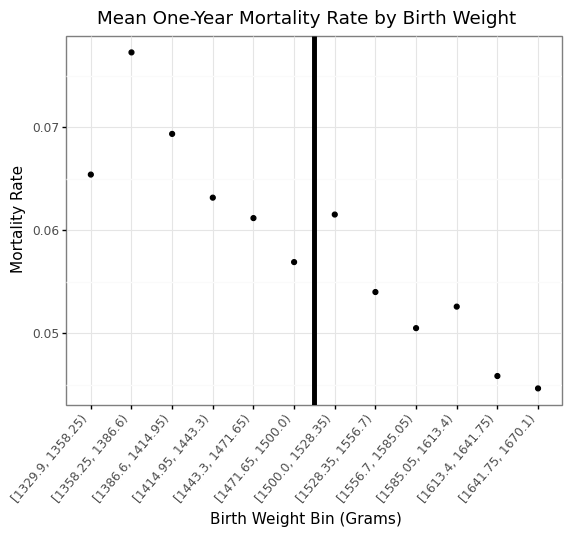

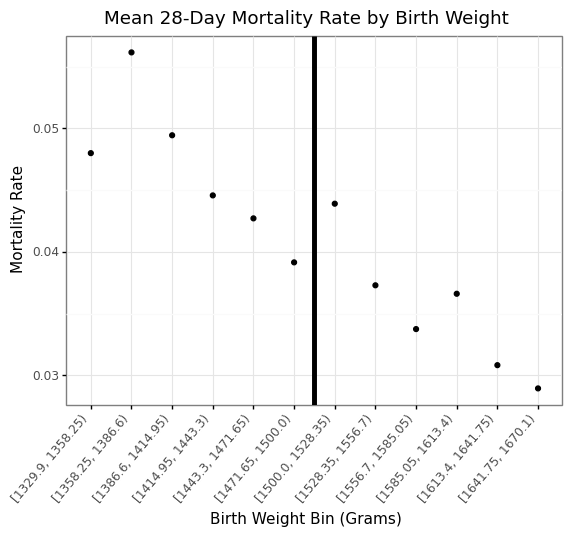

(<ggplot: (8791018862433)>, <ggplot: (8791016350237)>)

In [32]:
yearly_plot = plotter(dataframe=mortality_summary_df, x='bweight_bins', y='agedth5',
                      title='Mean One-Year Mortality Rate by Birth Weight',
                      x_axis_label='Birth Weight Bin (Grams)',
                      y_axis_label='Mortality Rate')

monthly_plot = plotter(dataframe=mortality_summary_df, x='bweight_bins', y='agedth4',
                       title='Mean 28-Day Mortality Rate by Birth Weight',
                       x_axis_label='Birth Weight Bin (Grams)',
                       y_axis_label='Mortality Rate')

yearly_plot, monthly_plot

In looking at the plots above, there is a negative relationship between birth weight and the mortality rate. As a newborn's birth weight increases, the mortality rate falls. Intuitively, this makes sense given that newborns who weigh more likely face fewer health complications. 

However, upon visual inspection of both the yearly and monthly mortality rate plots, there appears to be a *discontinuity* as we move from the bin directly below (1471.65 grams inclusive to 1500 grams exclusive) the 1500 gram threshold to the bin directly above the threshold (1500 grams inclusive to 1528.35 grams exclusive). In moving from left to the right on the x-axis, the mortality rate generally declines until reaching the threshold where it jumps up before falling back down again. 

In looking back at the grouped dataframe, the one-year mortality rate jumps from about 5.69% to 6.15%. When looking at the 28-day mortality rate, the rate jumps from about 3.91% to 4.39%. 

With this in mind, it's possible that the difference in the mortality rate in the vicinity of the threshold may be attributed to alternative treatments that newborns above and below the cutoff receive. 

# Evaluating the Assumption

As a reminder, for RDD estimates to hold, our assignment variable must not be manipulable. If we were able to manipulate the running variable, then any discontinuous jumps in the vicinity of the threshold may be attributed to manipulation and not treatment effects. 

Our running variable is birth weight. For our assumption to hold, birth weight cannot be manipulated. This is *likely met*. As the original researchers argue, birth weight cannot be manipulated to the degree of precision necessary to invalidate this assumption. According to [Pressman et al. (2000)](https://www.sciencedirect.com/science/article/abs/pii/S0029784499006171), birthweight cannot be predicted before birth with the necessary precision to change the newborn’s classification of above 1500 grams or below 1500 grams. In other words, while parents and doctors may have some influence in a baby’s birthweight either through maternal diet or inducing early birth, it is not plausible that they have the precision or control required to change the birthweight categorization of the newborn.

# Plotting the Background Covariates

Next, I'll plot mother's education, mother's age, mother's education less than high school, gestational age, prenatal care visits, and year of birth against birth weight. The idea here is to also expect smoothness around the threshold so that discontinuities around the threshold are again attributed treatment and not to a background characteristic of the mother (or some other variable).

In [9]:
background_covariates = ['mom_age', 'mom_ed1', 'gest', 'nprenatal', 'yob']
summary_stat = [['mean'] * 5]
summary_stat = [mean for sublist in summary_stat for mean in sublist]
background_aggregations = dict(zip(background_covariates, summary_stat))
background_summary = data_grouper(dataframe=df, 
                                  grouper_col='bweight_bins', 
                                  agg_dict=background_aggregations)
background_summary

,bweight_bins,mom_age,mom_ed1,gest,nprenatal,yob
0,"[1329.9, 1358.25)",26.764292,0.240599,31.111612,8.692638,1993.778661
1,"[1358.25, 1386.6)",26.211801,0.260021,31.225998,8.367048,1992.710015
2,"[1386.6, 1414.95)",26.437522,0.247293,31.401115,8.635597,1992.938866
3,"[1414.95, 1443.3)",26.460619,0.250876,31.548761,8.746612,1993.088415
4,"[1443.3, 1471.65)",26.487695,0.249645,31.745317,8.818672,1993.026664
5,"[1471.65, 1500.0)",26.436943,0.250489,31.899631,8.908753,1993.083331
6,"[1500.0, 1528.35)",26.387245,0.253558,32.136983,8.917313,1992.913425
7,"[1528.35, 1556.7)",26.452241,0.252207,32.348546,9.074383,1993.141750
8,"[1556.7, 1585.05)",26.454008,0.245460,32.453237,9.112997,1993.041816
9,"[1585.05, 1613.4)",26.424861,0.248136,32.626248,9.074674,1992.944753


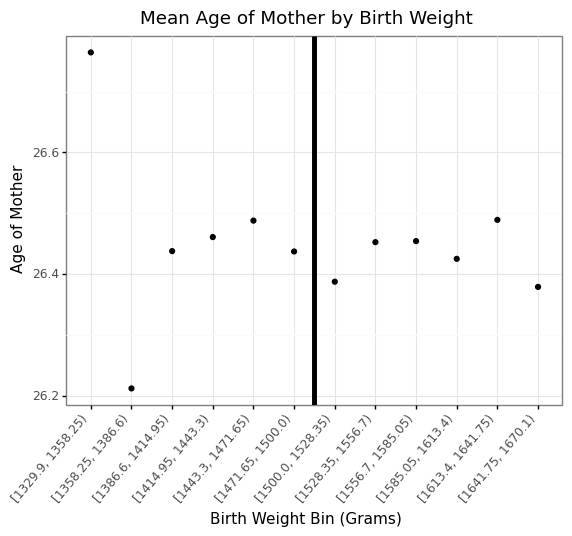

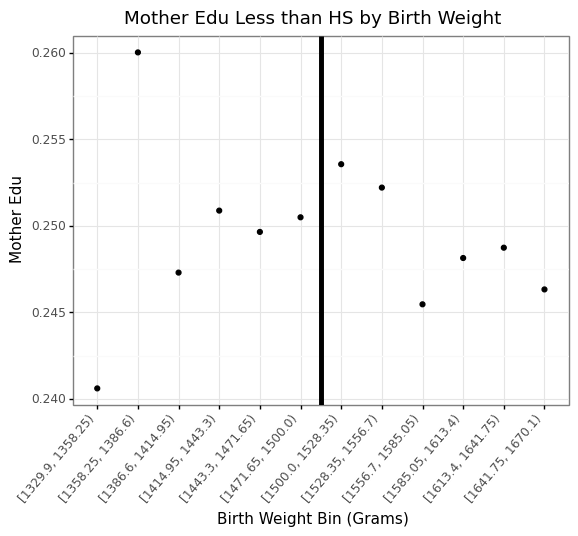

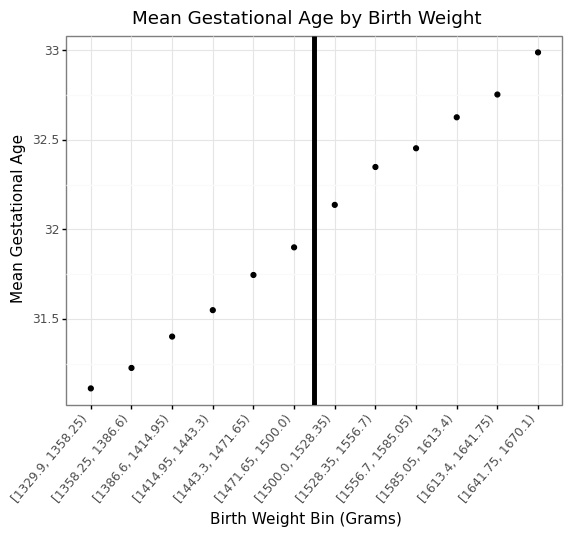

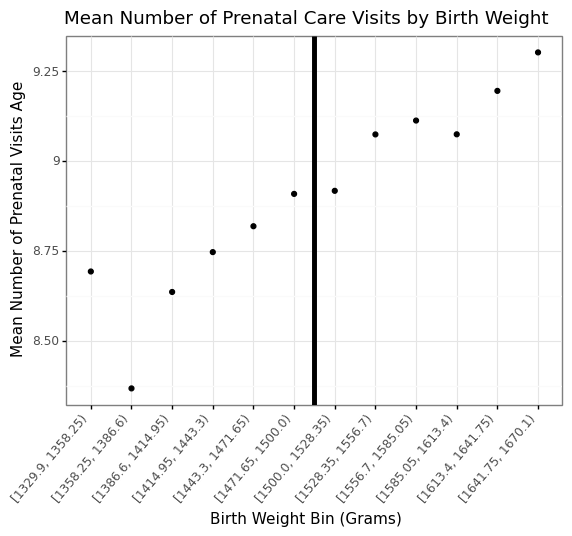

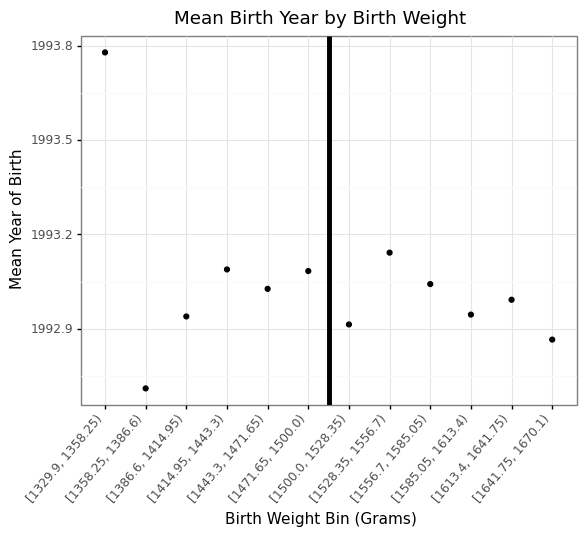

(<ggplot: (8791018645633)>,
 <ggplot: (8791018855033)>,
 <ggplot: (8791016317665)>,
 <ggplot: (8791016615581)>,
 <ggplot: (8791016314629)>)

In [33]:
mom_age_plot = plotter(dataframe=background_summary, x='bweight_bins', y='mom_age',
                       title='Mean Age of Mother by Birth Weight',
                       x_axis_label='Birth Weight Bin (Grams)',
                       y_axis_label='Age of Mother')
    
mom_hs_ed_plot = plotter(dataframe=background_summary, x='bweight_bins', y='mom_ed1',
                         title='Mother Edu Less than HS by Birth Weight',
                         x_axis_label='Birth Weight Bin (Grams)',
                         y_axis_label='Mother Edu')
    
gestation_plot = plotter(dataframe=background_summary, x='bweight_bins', y='gest',
                         title='Mean Gestational Age by Birth Weight',
                         x_axis_label='Birth Weight Bin (Grams)',
                         y_axis_label='Mean Gestational Age')
    
prenatal_plot = plotter(dataframe=background_summary, x='bweight_bins', y='nprenatal',
                         title='Mean Number of Prenatal Care Visits by Birth Weight',
                         x_axis_label='Birth Weight Bin (Grams)',
                         y_axis_label='Mean Number of Prenatal Visits Age')
    
yob_plot = plotter(dataframe=background_summary, x='bweight_bins', y='yob',
                   title='Mean Birth Year by Birth Weight',
                   x_axis_label='Birth Weight Bin (Grams)',
                   y_axis_label='Mean Year of Birth')

mom_age_plot, mom_hs_ed_plot, gestation_plot, prenatal_plot, yob_plot

From the plots above, gestational age and number of prenatal care visits show smooth, clear trends around the cutoff. However, mother's age, mother's education less than high school, and birth year are more erratic, suggesting discontinuities around the cutoff. With this in mind, we can control for these variables by adding them as regressors later on in the analysis. In the next section, I run the regression without these covariates. 